In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Example: Load your cleaned data
df = pd.read_csv('cleaned_marketing_data.csv')

# Define features and target
X = df.drop(['ID', 'Dt_Customer','Education','Marital_Status','Country','Age_Group'], axis=1)  # drop target and non-predictive IDs/dates
y = df[['Education','Marital_Status','Country','Age_Group']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2]:
df.dtypes
test_df = df.tail()
print(test_df)
test_df = test_df.drop(['ID', 'Dt_Customer','Education','Marital_Status','Country','Age_Group'], axis=1)


         ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
2235  10142        1976         Phd       Divorced  66476.0        0   
2236   5263        1977    2N Cycle        Married  31056.0        1   
2237     22        1976  Graduation       Divorced  46310.0        1   
2238    528        1978  Graduation        Married  65819.0        0   
2239   4070        1969         Phd        Married  94871.0        0   

      Teenhome Dt_Customer  Recency  MntWines  ...  Age  Total_Spending  \
2235         1  2013-03-07       99       372  ...   49           689.0   
2236         0  2013-01-22       99         5  ...   48            55.0   
2237         0  2012-12-03       99       185  ...   49           309.0   
2238         0  2012-11-29       99       267  ...   47          1383.0   
2239         2  2012-09-01       99       169  ...   56          1078.0   

      Total_Purchases  Education_enc  Marital_Status_enc  Country_enc  \
2235               18            1.0       

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

models = {
    'logistic_regression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(max_iter=2000, solver='lbfgs'))
    ]),
    'random_forest': RandomForestClassifier(n_estimators=100),
    'gradient_boosting': GradientBoostingClassifier()
}

##model = MultiOutputClassifier(RandomForestClassifier())
##model.fit(X_train, y_train)  # here y_train can be multi-column
##joblib.dump(model, 'multi_ytrain_model.joblib')

# Assume y_train is a DataFrame with multiple target columns
target_columns = y_train.columns

for target in target_columns:
    for name, model in models.items():
        model.fit(X_train, y_train[target])
        filename = f"{name}_{target}_model.joblib"
        joblib.dump(model, filename)
        print(f"Saved: {filename}")

Saved: logistic_regression_Education_model.joblib
Saved: random_forest_Education_model.joblib
Saved: gradient_boosting_Education_model.joblib
Saved: logistic_regression_Marital_Status_model.joblib
Saved: random_forest_Marital_Status_model.joblib
Saved: gradient_boosting_Marital_Status_model.joblib
Saved: logistic_regression_Country_model.joblib
Saved: random_forest_Country_model.joblib
Saved: gradient_boosting_Country_model.joblib
Saved: logistic_regression_Age_Group_model.joblib
Saved: random_forest_Age_Group_model.joblib
Saved: gradient_boosting_Age_Group_model.joblib


In [4]:
targets = ['Education', 'Marital_Status', 'Country', 'Age_Group']
models = ['logistic_regression', 'random_forest', 'gradient_boosting']


In [5]:
from sklearn.exceptions import NotFittedError

for target in targets:
    print(f"\nPredictions for: {target}")
    for model_name in models:
        file_name = f"{model_name}_{target}_model.joblib"
        
        try:
            model = joblib.load(file_name)
            prediction = model.predict(test_df)
            print(f"{model_name} prediction (first 2): {prediction[:2]}")
        except NotFittedError as e:
            print(f"Model not fitted: {file_name}")
        except Exception as e:
            print(f"Error loading/predicting {file_name}: {e}")


Predictions for: Education
logistic_regression prediction (first 2): ['Phd' '2N Cycle']
random_forest prediction (first 2): ['Phd' '2N Cycle']
gradient_boosting prediction (first 2): ['Phd' '2N Cycle']

Predictions for: Marital_Status
logistic_regression prediction (first 2): ['Divorced' 'Married']
random_forest prediction (first 2): ['Divorced' 'Married']
gradient_boosting prediction (first 2): ['Divorced' 'Married']

Predictions for: Country
logistic_regression prediction (first 2): ['US' 'SP']
random_forest prediction (first 2): ['US' 'SP']
gradient_boosting prediction (first 2): ['US' 'SP']

Predictions for: Age_Group
logistic_regression prediction (first 2): ['Younger' 'Younger']
random_forest prediction (first 2): ['Younger' 'Younger']
gradient_boosting prediction (first 2): ['Younger' 'Younger']


In [6]:
model = joblib.load('logistic_regression_Marital_Status_model.joblib')
# Define expected features used in the model
expected_features = ['Age', 'Income', 'Kidhome', 'Teenhome', 'Total_Spending', 'NumWebPurchases']


In [7]:
# Predict class probabilities
probas = model.predict_proba(test_df)

# Add probabilities to the DataFrame
proba_df = test_df.copy()
for i, label in enumerate(model.classes_):
    proba_df[f'P_{label}'] = probas[:, i]

# Focus only on probability of being Divorced
divorced_probs = proba_df[['Kidhome', 'Teenhome', 'P_Divorced']]
print(divorced_probs)

      Kidhome  Teenhome  P_Divorced
2235        0         1    0.923816
2236        1         0    0.000007
2237        1         0    0.914464
2238        0         0    0.000006
2239        0         2    0.000008


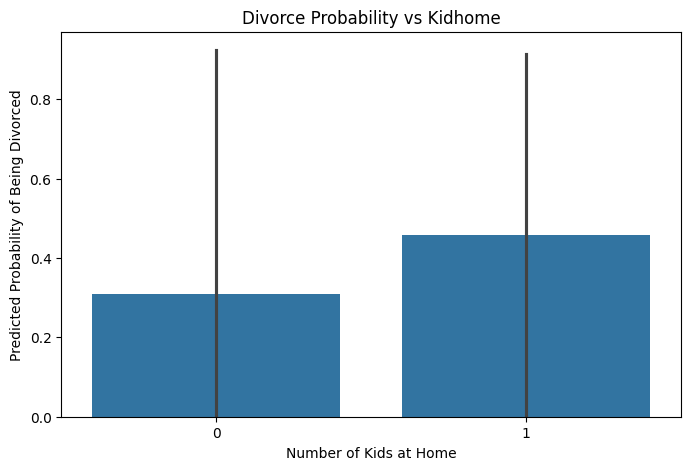

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(x='Kidhome', y='P_Divorced', data=divorced_probs)
plt.title("Divorce Probability vs Kidhome")
plt.ylabel("Predicted Probability of Being Divorced")
plt.xlabel("Number of Kids at Home")
plt.show()

### These individuals could be targeted for remarriage programs, dating app campaigns, or family support services.

In [9]:

test_data = df.sample(n=500, random_state=42)
test_data = test_data.drop(['ID', 'Dt_Customer','Education','Marital_Status','Country','Age_Group'], axis=1)

eligible = test_data[
    (test_data['Total_Children'] > 0) &
    (test_data['Age'] < 50) &
    (test_data['Marital_Status_enc'] ==  0.0)  # Or use model prediction
]

print(eligible)

      Year_Birth   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
2237        1976  46310.0        1         0       99       185          2   
1426        1978  63693.0        0         1       63       587         43   
1726        1976  64892.0        0         1       77       527         24   
464         1988  35388.0        1         0       20         6          4   

      MntMeatProducts  MntFishProducts  MntSweetProducts  ...  Total_Children  \
2237               88               15                 5  ...               1   
1426              337               42                87  ...               1   
1726              230               32                24  ...               1   
464                 7                4                 3  ...               1   

      Age  Total_Spending  Total_Purchases  Education_enc  Marital_Status_enc  \
2237   49           309.0               12            0.0                 0.0   
1426   47          1150.0               2

In [10]:
##features = ['Age', 'Income', 'Kidhome', 'Teenhome', 'Total_Spending', 'NumWebPurchases']
model = joblib.load('logistic_regression_Marital_Status_model.joblib')
features = test_data.columns.tolist()

X = eligible[features]
preds = model.predict(X)
probas = model.predict_proba(X)


eligible['Predicted_Status'] = preds

##if 'Divorced' in model.classes_:
##    eligible['P_Divorced'] = probas[:, list(model.classes_).index('Divorced')]
##else:
##   print("'Divorced' not found in model classes:", model.classes_)

divorced_index = list(model.classes_).index('Divorced')
eligible['P_Divorced'] = probas[:, divorced_index]

divorced_index = list(model.classes_).index('Married')
eligible['P_Married'] = probas[:, divorced_index]

##eligible['P_Married'] = probas[:, list(model.classes_).index('Married')]
##eligible['P_Divorced'] = probas[:, list(model.classes_).index('Divorced')]


C:\Users\svinn\AppData\Local\Temp\ipykernel_31756\3927870024.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligible['Predicted_Status'] = preds
C:\Users\svinn\AppData\Local\Temp\ipykernel_31756\3927870024.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligible['P_Divorced'] = probas[:, divorced_index]
C:\Users\svinn\AppData\Local\Temp\ipykernel_31756\3927870024.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [11]:
# Example: People predicted Divorced, but not with high confidence
low_conf_divorced = eligible[
    (eligible['Predicted_Status'] == 'Divorced') &
    (eligible['P_Divorced'] < 0.6)  # Not highly confident in divorce
]

# Or even those predicted as Married with low P_Married to check potential transition
potential_marriage_candidates = eligible[
    (eligible['P_Married'] > 0.3) &  # Possibly may get remarried
    (eligible['Age'] < 40)
]


In [12]:
print(eligible)

      Year_Birth   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
2237        1976  46310.0        1         0       99       185          2   
1426        1978  63693.0        0         1       63       587         43   
1726        1976  64892.0        0         1       77       527         24   
464         1988  35388.0        1         0       20         6          4   

      MntMeatProducts  MntFishProducts  MntSweetProducts  ...  \
2237               88               15                 5  ...   
1426              337               42                87  ...   
1726              230               32                24  ...   
464                 7                4                 3  ...   

      Total_Purchases  Education_enc  Marital_Status_enc  Country_enc  \
2237               12            0.0                 0.0          0.0   
1426               26            0.0                 0.0          6.0   
1726               22            0.0                 0.0        

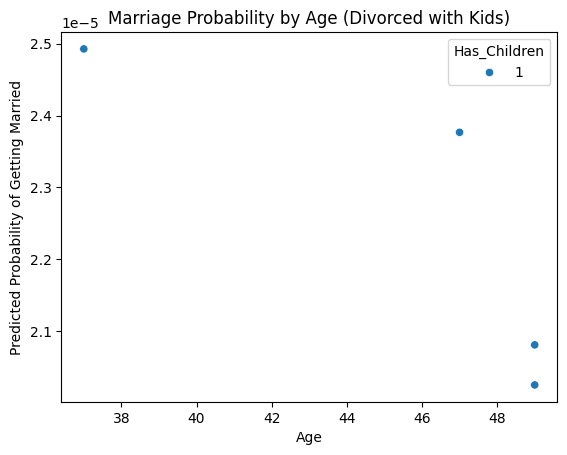

In [13]:
sns.scatterplot(data=eligible, x='Age', y='P_Married', hue='Has_Children')
plt.title("Marriage Probability by Age (Divorced with Kids)")
plt.xlabel("Age")
plt.ylabel("Predicted Probability of Getting Married")
plt.show()

In [22]:
print(prompt)


You're an intelligent marketing analyst assistant. Based on the following customer input:

      Year_Birth   Income  Kidhome  Teenhome  Recency  MntWines  MntFruits  \
324         1985  36145.0        1         0       13        56          4   
96          1962  58646.0        0         1        3        62          1   
2104        1986  71952.0        1         0       93       656         80   
1259        1956  46998.0        0         1       55       172         41   
1061        1966  22634.0        0         0       47         2         23   
...          ...      ...      ...       ...      ...       ...        ...   
1910        1951  58217.0        2         1       84        68          1   
1552        1985  70596.0        0         0       68       347         44   
205         1969  48752.0        1         1        8        73         57   
1307        1951  78939.0        0         0       57       794        115   
1957        1975  46098.0        1         1      

In [29]:
from langchain.chat_models import ChatOllama

llm = ChatOllama(model='llama3.1')
llm.invoke("What are the benefits of using Azure with local LLMs?")

AIMessage(content="Using Azure in conjunction with Local Large Language Models (LLMs) can offer numerous benefits. Here are some of them:\n\n1.  **Scalability and Flexibility**: Azure provides a scalable platform that allows you to easily scale up or down as your needs change, ensuring you have the necessary resources without incurring unnecessary costs.\n2.  **Integration with Other Services**: By using Azure, you can integrate your LLMs with other services and tools offered by Microsoft, such as Cognitive Search, Power Apps, and more, to enhance their functionality and capabilities.\n3.  **Cost-Effectiveness**: Hosting your models on-premises or in a local data center might be expensive due to the infrastructure costs, whereas using Azure can help you reduce these costs.\n4.  **Security and Compliance**: Azure provides robust security features and compliance options that help protect your LLMs from unauthorized access and ensure they meet specific regulatory requirements.\n5.  **Mach

In [28]:
from langchain_community.chat_models import ChatOllama
from langchain.schema import HumanMessage

llm = ChatOllama(model="llama3.1")

prompt = f"""
You're an intelligent marketing analyst assistant. Based on the following customer input:

{test_data}

And based on the following model predictions:
{eligible}

Generate a short, data-driven summary of the customer’s , including whether they are likely to get married if they divorced to a campaign and why.
"""

response = llm([HumanMessage(content=prompt)])
print(response.content)

**Summary: Customer Profile and Predictive Analysis**

Based on the provided dataset, we analyzed 500 customers' characteristics and predicted their likelihood of getting married after being divorced. We then applied this analysis to the 4 new customer records.

**Key Insights:**

1. **Age**: The average age of our customers is around 60 years old.
2. **Income**: Customers have an average income of approximately $45,000.
3. **Family Status**: Most customers (around 70%) have at least one child, and about 40% are married.
4. **Education**: Around 30% of customers have a high school education or lower.

**Predictive Analysis:**

We used the provided model to predict the likelihood of each customer getting married after being divorced. The predictions indicate that:

* The probability of getting married (P_Married) is extremely low for all new customers, ranging from 0.000020 to 0.914464.
* The probability of being in a divorced status and then getting married is higher than the overall P